In [1]:
# IMPORTS
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import os
import pandas as pd
from skimage import color
from skimage import io
from sklearn.metrics import confusion_matrix
import seaborn as sn

In [2]:

drive = True

if drive:
    from google.colab import drive
    # MOUNT DRIVE
    drive.mount('/content/drive', force_remount=True)
    data_path = '/content/drive/My Drive/DeepLearning_2023/Final/Data/'
    raw_data_path = '/content/drive/My Drive/DeepLearning_2023/Final/Data/raw_samples/'
    synth_data_path = '/content/drive/My Drive/DeepLearning_2023/Final/Data/synth_samples/'
    results_path = '/content/drive/My Drive/DeepLearning_2023/Final/Results/'
else: # LOCAL
    data_path = './Data/'
    raw_data_path = './Data/raw_samples/'
    results_path = './Results/'

Mounted at /content/drive


In [3]:
# UTILS
def one_hot_encode_multiple_classes(array, n_classes=36):
    output = [0]*(len(array)*n_classes)
    for i, _class in enumerate(array):
        output[(i)*(n_classes) + (_class)] = 1
    return output

def one_hot_decode_multiple_classes(one_hot, n_classes=36):
    length = len(one_hot)//n_classes
    output = [0]*length
    for i in range(length):
        _class = np.argmax(one_hot[(i*n_classes):((i+1)*n_classes)])
        output[i] = _class
    return output

def all_character_to_int(array):
    output = [single_character_to_int(c) for c in array]
    return output

def all_int_to_character(array):
    output = [int_to_single_character(int(i)) for i in array]
    return output

def single_character_to_int(c): # Converts char to int label
    if c.isdigit():
        return int(c)
    else:
        return int(ord(c) - 87)

def int_to_single_character(i): # Converts int label to char
    if i<10:
        return str(i)
    else:
        return str(chr(int(i) + 87))

def squareImage(img, target_size = 192): # INPUT IMG MUST BE PIL IMAGE RGBA: RETURNS NUMPY ARRAY OF SIZE 192x192x4
    if img.mode == "RGBA":
        channels = 4
    elif img.mode == "RGB":
        channels = 3
    else:
        print("Image with wrong mode")
    img_np = np.array(img.getdata()).reshape(img.size[1], img.size[0], channels)
    #PADDING
    y,x,_ = img_np.shape
    pad_y = max(0, (target_size - y)//2)
    pad_x = max(0, (target_size - x)//2)
    img_np = np.pad(img_np, ((pad_y, pad_y),(pad_x, pad_x),(0, 0)), "edge")
    # CROPPING
    y,x,_ = img_np.shape
    startx = x//2-(target_size//2)
    starty = y//2-(target_size//2)
    img_np = img_np[starty:starty+192,startx:startx+192]
    return img_np

In [4]:
#CaptchaDataset class
class CaptchaDataset(torch.utils.data.Dataset):
    #characters = ['a''b''c''d''e''f''g''h''i''j''k''l''m''n''o''p''q''r''t''u''v''w''x''y''z']
    #numbers = ['1''2''3''4''5''6''7''8''9''10''11''12''13''14''15''16''17''18''19''20''21''22''23''24']
    # Initialization method for the dataset
    def __init__(self, dataPath = raw_data_path, transform = None, target_char=0):
        self.data = []
        self.labels = []
        directory_files = os.listdir(dataPath)
        for filename in directory_files:
            self.data.append(np.array(squareImage(Image.open(dataPath+filename)))[:,:,0])
            #self.data.append(np.array(Image.open(dataPath+filename))[:,:,0])
            #self.labels.append(filename[:-4])
            self.labels.append(single_character_to_int(filename[target_char]))
        self.data=np.array(self.data)
        self.transform = transform

    # What to do to load a single item in the dataset ( read image and label)
    def __getitem__(self, index):
        data = self.data[index]
        lbl = self.labels[index]
        data = Image.fromarray((data).astype(np.uint8))
        # Apply a trasnformaiton to the image if it is indicated in the initalizer
        if self.transform is not None :
            data = self.transform(data)

        # return the image and the label
        return data,lbl

    # Return the number of images
    def __len__(self):
        return self.data.shape[0]

#CaptchaDataset class
class CaptchaDatasetFull(torch.utils.data.Dataset):
    # Initialization method for the dataset
    def __init__(self, dataPath = raw_data_path, transform = None):
        self.data = []
        self.labels = []
        directory_files = os.listdir(dataPath)
        for filename in directory_files:
            self.data.append(np.array(squareImage(Image.open(dataPath+filename)))[:,:,0])
            self.labels.append(all_character_to_int(list(filename[:5])))
        self.data=np.array(self.data)
        self.transform = transform

    # What to do to load a single item in the dataset ( read image and label)
    def __getitem__(self, index):
        data = self.data[index]
        lbl = torch.Tensor(self.labels[index])
        data = Image.fromarray((data).astype(np.uint8))
        # Apply a trasnformaiton to the image if it is indicated in the initalizer
        if self.transform is not None :
            data = self.transform(data)

        # return the image and the label
        return data,lbl

    # Return the number of images
    def __len__(self):
        return self.data.shape[0]

In [9]:
class MyMobileNetV2(nn.Module):
    def __init__(self, num_classes=36):
        super(MyMobileNetV2, self).__init__()

        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.dropout1 = nn.Dropout(0.05)
        t = 1
        self.conv20 = nn.Conv2d(16, 16*t, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn20 = nn.BatchNorm2d(16*t)
        self.conv21 = nn.Conv2d(16*t, 16, kernel_size=3, stride=1, padding=1, groups=16, bias=False)
        self.bn21 = nn.BatchNorm2d(16)
        self.conv22 = nn.Conv2d(16, 32, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn22 = nn.BatchNorm2d(32)

        t = 4
        self.conv30 = nn.Conv2d(32, 32*t, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn30 = nn.BatchNorm2d(32*t)
        self.conv31 = nn.Conv2d(32*t, 32, kernel_size=3, stride=1, padding=1, groups=32, bias=False)
        self.bn31 = nn.BatchNorm2d(32)
        self.conv32 = nn.Conv2d(32, 64, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn32 = nn.BatchNorm2d(64)

        self.conv40 = nn.Conv2d(64, 64*t, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn40 = nn.BatchNorm2d(64*t)
        self.conv41 = nn.Conv2d(64*t, 64, kernel_size=3, stride=1, padding=1, groups=64, bias=False)
        self.bn41 = nn.BatchNorm2d(64)
        self.conv42 = nn.Conv2d(64, 128, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn42 = nn.BatchNorm2d(128)
        self.dropout4 = nn.Dropout(0.05)

        self.conv50 = nn.Conv2d(128, 128*t, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn50 = nn.BatchNorm2d(128*t)
        self.conv51 = nn.Conv2d(128*t, 128, kernel_size=3, stride=1, padding=1, groups=128, bias=False)
        self.bn51 = nn.BatchNorm2d(128)
        self.conv52 = nn.Conv2d(128, 128, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn52 = nn.BatchNorm2d(128)

        self.conv60 = nn.Conv2d(128, 128*t, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn60 = nn.BatchNorm2d(128*t)
        self.conv61 = nn.Conv2d(128*t, 128, kernel_size=3, stride=1, padding=1, groups=128, bias=False)
        self.bn61 = nn.BatchNorm2d(128)
        self.conv62 = nn.Conv2d(128, 256, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn62 = nn.BatchNorm2d(256)

        t = 4
        self.conv70 = nn.Conv2d(256, 256*t, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn70 = nn.BatchNorm2d(256*t)
        self.conv71 = nn.Conv2d(256*t, 256, kernel_size=3, stride=1, padding=1, groups=256, bias=False)
        self.bn71 = nn.BatchNorm2d(256)
        self.conv72 = nn.Conv2d(256, 256, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn72 = nn.BatchNorm2d(256)
        self.dropout7 = nn.Dropout(0.05)

        self.conv80 = nn.Conv2d(256, 256*t, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn80 = nn.BatchNorm2d(256*t)
        self.conv81 = nn.Conv2d(256*t, 256, kernel_size=3, stride=1, padding=1, groups=256, bias=False)
        self.bn81 = nn.BatchNorm2d(256)
        self.conv82 = nn.Conv2d(256, 512, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn82 = nn.BatchNorm2d(512)

        t=1
        self.conv90 = nn.Conv2d(512, 512*t, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn90 = nn.BatchNorm2d(512*t)
        self.conv91 = nn.Conv2d(512*t, 512, kernel_size=3, stride=1, padding=1, groups=256, bias=False)
        self.bn91 = nn.BatchNorm2d(512)
        self.conv92 = nn.Conv2d(512, 512, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn92 = nn.BatchNorm2d(512)

        self.relu6 = nn.ReLU6(inplace=True)
        self.MaxPool2d= nn.MaxPool2d(kernel_size=2, stride=2)
        self.AvgPool2d = nn.AvgPool2d(12)
        #self.fc1 = nn.Linear(1024, 512)
        self.dropoutFc = nn.Dropout(0.1)
        #self.fc2 = nn.Linear(512, 512)
        self.fc = nn.Linear(512, num_classes)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear) or  isinstance(m, nn.Conv2d):
           nn.init.xavier_uniform_(m.weight)

    def forward(self, x):

        #print(x.shape) -> INPUT: (192, 192, 1)
        out = self.relu6(self.bn1(self.conv1(x))) #-> OUTPUT: (192, 192, 16)
        out = self.dropout1(out)
        out = self.relu6(self.bn22(self.conv22(self.relu6(self.bn21(self.conv21(self.relu6(self.bn20(self.conv20(out))))))))) #-> OUTPUT: (192, 192, 32)
        out = self.MaxPool2d(out) #-> OUTPUT: (96, 96, 32)
        out = self.relu6(self.bn32(self.conv32(self.relu6(self.bn31(self.conv31(self.relu6(self.bn30(self.conv30(out))))))))) #-> OUTPUT: (96, 96, 64)
        out = self.relu6(self.bn42(self.conv42(self.relu6(self.bn41(self.conv41(self.relu6(self.bn40(self.conv40(out))))))))) #-> OUTPUT: (96, 96, 128)
        out = self.dropout4(out)
        out = self.MaxPool2d(out) #-> OUTPUT: (48, 48, 128)
        out = self.relu6(self.bn52(self.conv52(self.relu6(self.bn51(self.conv51(self.relu6(self.bn50(self.conv50(out)))))))))+out  #-> OUTPUT: (48, 48, 128)
        out = self.relu6(self.bn62(self.conv62(self.relu6(self.bn61(self.conv61(self.relu6(self.bn60(self.conv60(out)))))))))  #-> OUTPUT: (48, 48, 256)
        out = self.relu6(self.bn72(self.conv72(self.relu6(self.bn71(self.conv71(self.relu6(self.bn70(self.conv70(out)))))))))+out #-> OUTPUT: (48, 48, 256)
        out = self.dropout7(out)
        out = self.MaxPool2d(out) #-> OUTPUT: (24, 24, 256)
        out = self.relu6(self.bn82(self.conv82(self.relu6(self.bn81(self.conv81(self.relu6(self.bn80(self.conv80(out))))))))) #-> OUTPUT: (24, 24, 512)
        out = self.MaxPool2d(out) #-> OUTPUT: (12, 12, 512)
        out = self.relu6(self.bn92(self.conv92(self.relu6(self.bn91(self.conv91(self.relu6(self.bn90(self.conv90(out))))))))) #-> OUTPUT: (12, 12, 512)
        out = self.AvgPool2d(out) #-> OUTPUT: (1, 1, 512)
        out = torch.flatten(out, 1)
        #out = self.fc1(out)
        out = self.dropoutFc(out)
        #out = self.fc2(out)
        out = self.fc(out)
        return out

In [10]:
# Compute model paramters
def compute_model_params(model):
  params = 0
  for p in model.parameters():
    params += p.numel()
  return params
model = MyMobileNetV2(num_classes=36)
print("Parametres:",compute_model_params(model))

Parametres: 1530532


In [13]:
# Train function
def train(CNN, train_loader, optimizer, num_epochs=5, model_name='model.ckpt', device='cpu', test_loader=None):
    CNN.train() # Set the model in train mode
    total_step = len(train_loader)
    losses_list = []
    accuracies = []
    maxloss= 10000000
    criterion = nn.CrossEntropyLoss()
    # Iterate over epochs
    for epoch in range(num_epochs):
        # Iterate the dataset
        loss_avg = 0
        nBatches = 0
        for i, (images, labels) in enumerate(train_loader):
            # Get batch of samples and labels
            images = images.to(device)
            labels = labels.type(torch.LongTensor).to(device)

            # Forward pass
            outputs = CNN(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_avg += loss.cpu().item()
            nBatches+=1
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                       .format(epoch+1, num_epochs, i+1, total_step, loss_avg / nBatches))
        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                       .format(epoch+1, num_epochs, i+1, total_step, loss_avg / nBatches))
        losses_list.append(loss_avg / nBatches)
        if test_loader != None:
            CNN.eval()
            acc = test(CNN, test_loader)
            accuracies.append(acc)
            print("Accuracy: {:.4f}%".format(acc))
            CNN.train()

        if loss<maxloss:
          torch.save(CNN.state_dict(), results_path+ '/' + model_name)
          maxloss = loss

    return losses_list, accuracies

# Test funcion
def test(CNN, test_loader, display_errors=False):
    CNN.eval()
    with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                # get network predictions
                outputs = CNN(images)

                # get predicted class
                _, predicted = torch.max(outputs.data, 1)

                # compare with the ground-truth
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                if display_errors:
                    for i in range(max(5, len(labels))):
                        if predicted[i] != labels[i]:
                            print('Real label: ' + str(labels[i]))
                            print('Predicted label: ' + str(predicted[i]))
                            print(display(plt.imshow(images[i][0].cpu().numpy())))
                            plt.show()
            # return accuracy
            return 100 * correct / total

def get_full_accuracy (CNNs_5, test_loader):
    for CNN in CNNs_5:
        CNN.eval()
    with torch.no_grad():
        correct_full_captcha = 0
        total_captchas = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            out1 = CNNs_5[0](images)
            out2 = CNNs_5[1](images)
            out3 = CNNs_5[2](images)
            out4 = CNNs_5[3](images)
            out5 = CNNs_5[4](images)

            _, predicted1 = torch.max(out1, 1)
            _, predicted2 = torch.max(out2, 1)
            _, predicted3 = torch.max(out3, 1)
            _, predicted4 = torch.max(out4, 1)
            _, predicted5 = torch.max(out5, 1)

            predicted1 = torch.cat((predicted1, predicted2), 0)
            predicted1 = torch.cat((predicted1, predicted3), 0)
            predicted1 = torch.cat((predicted1, predicted4), 0)
            predicted1 = torch.cat((predicted1, predicted5), 0)

            batch_size = len(labels)
            predicted1 = torch.transpose(torch.reshape(predicted1, (5, batch_size)), 0, 1)

            total_captchas += labels.size(0)

            correct_full_captcha += (predicted1 == labels).prod(dim=1).sum().item()

        # return accuracy
        return 100*correct_full_captcha/total_captchas

def compute_confusion_matrix(CNNs_5, test_loader): # STILL NEEDS TO BE IMPLEMENTED
    CNN.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            # get network predictions
            outputs = CNN(images)
            batch_size = len(outputs)
            outputs = torch.reshape(outputs, (batch_size, 36, 5))
            # get predicted class
            _, predicted = torch.max(outputs.data, 1)
            predicted = predicted.flatten()
            labels = labels.flatten()

            confusion = confusion_matrix(labels.cpu().numpy(), predicted.cpu().numpy())
    classes = ("2", "3", "4", "5", "6", "7", "8", "b", "c", "d", "e", "f", "g", "m", "n", "p", "w", "x", "y")
    df_cm = pd.DataFrame(confusion / np.sum(confusion, axis=1)[:, None], index = [i for i in classes], columns = [i for i in classes])
    return df_cm

## 5 CNNs (one for each of the 5 characters)

In [14]:
# Image transformer
tr = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean = [.5], std = [.5])
        ])

CAPTCHA_LEN = 5

captchaDatasets_by_target = []
train_sets = []
test_sets = []

for i in range(CAPTCHA_LEN):
#Instantiating captchaDataset
    captchaDatasets_by_target.append(CaptchaDataset(raw_data_path, tr, target_char = i))
    train_sets.append(None)
    test_sets.append(None)
    train_size = int(len(captchaDatasets_by_target[i]) * 0.7)
    test_size = len(captchaDatasets_by_target[i]) - train_size
    train_sets[i], test_sets[i] = torch.utils.data.random_split(captchaDatasets_by_target[i],[train_size,test_size], generator=torch.Generator().manual_seed(42))

In [15]:
CAPTCHA_LEN = 5

# CURRENT BEST: epochs=20, lr=0.00075
epochs = 50 # USE 12-14 with .001 or 20 with .00075
learning_rate = .001 # CURRENT BEST: .001 or .00075
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

CNNs_5 = []
optimizers = []
train_loaders = []
losses_lists = []
accuracies_by_epoch = []

for i in range(5):
    CNNs_5.append(MyMobileNetV2(num_classes=36))
    optimizers.append(torch.optim.Adam(CNNs_5[i].parameters(),lr = learning_rate))
    CNNs_5[i] = CNNs_5[i].to(device)
    train_loaders.append(torch.utils.data.DataLoader(dataset=train_sets[i], batch_size=32, shuffle=True))
    test_loader = torch.utils.data.DataLoader(dataset=test_sets[i], batch_size=256, shuffle=True)
    print("TRAINING CNN FOR CHARACTER", i)
    loss_list_aux, acc_aux = train(CNNs_5[i], train_loaders[i], optimizers[i], num_epochs=epochs, device=device, model_name="char" + str(i) +"_model.ckpt", test_loader=test_loader)
    losses_lists.append(loss_list_aux)
    accuracies_by_epoch.append(acc_aux)

TRAINING CNN FOR CHARACTER 0
Epoch [1/50], Step [24/24], Loss: 3.0955
Accuracy: 9.2593%
Epoch [2/50], Step [24/24], Loss: 2.5832
Accuracy: 4.9383%
Epoch [3/50], Step [24/24], Loss: 2.3828
Accuracy: 19.4444%
Epoch [4/50], Step [24/24], Loss: 2.0837
Accuracy: 11.4198%
Epoch [5/50], Step [24/24], Loss: 1.5679
Accuracy: 42.5926%
Epoch [6/50], Step [24/24], Loss: 1.0809
Accuracy: 57.7160%
Epoch [7/50], Step [24/24], Loss: 0.6683
Accuracy: 15.1235%
Epoch [8/50], Step [24/24], Loss: 0.3758
Accuracy: 64.8148%
Epoch [9/50], Step [24/24], Loss: 0.1723
Accuracy: 93.5185%
Epoch [10/50], Step [24/24], Loss: 0.0975
Accuracy: 88.8889%
Epoch [11/50], Step [24/24], Loss: 0.0707
Accuracy: 79.0123%
Epoch [12/50], Step [24/24], Loss: 0.0340
Accuracy: 95.6790%
Epoch [13/50], Step [24/24], Loss: 0.0207
Accuracy: 99.6914%
Epoch [14/50], Step [24/24], Loss: 0.0137
Accuracy: 99.6914%
Epoch [15/50], Step [24/24], Loss: 0.0111
Accuracy: 99.0741%
Epoch [16/50], Step [24/24], Loss: 0.0092
Accuracy: 99.6914%
Epoch 

In [16]:

#CaptchaDatasetFull
# Image transformer
tr = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean = [.5], std = [.5])
        ])

#Instantiating captchaDataset
captchaDatasetFull = CaptchaDatasetFull(raw_data_path, tr)
print("captchaDataset created:")
print(" ", captchaDatasetFull.data.shape)

#SPLIT amb la mateixa seeed que els altres splits
# Setting train and test sizes

# Dataset splitting (inputs Dataset and outputs a dataset.Subset (which has same properties and methods as Dataset)))
train_set_full, test_set_full = torch.utils.data.random_split(captchaDatasetFull,[train_size,test_size], generator=torch.Generator().manual_seed(42))

#Test loader de capthca dataset full
test_loader_full = torch.utils.data.DataLoader(dataset=test_set_full, batch_size=256, shuffle=True)

captchaDataset created:
  (1080, 192, 192)


In [17]:
# Show results for all the trained models

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
accuracies5 = []
min_acc = 100
CNNs_5=[]
for i in range(5):
    test_loader = torch.utils.data.DataLoader(dataset=test_sets[i], batch_size=256, shuffle=True)
    CNNs_5.append(MyMobileNetV2(num_classes=36))
    CNNs_5[i].load_state_dict(torch.load(results_path + "char" + str(i) +"_model.ckpt"))
    CNNs_5[i].cuda()

    acc = test(CNNs_5[i], test_loader, display_errors=False)
    print('Accuracy for char ' + str(i) + ': ' + str(round(acc, 3)) + "%")
    accuracies5.append(acc)
    min_acc -= (100-acc)


full_captcha_accuracy = get_full_accuracy(CNNs_5, test_loader_full)
print("Overall min accuracy: " + str(round(min_acc, 3)) + "%")
print("Overall max accuracy: " + str(round(min(accuracies5), 3)) + "%")
print("Full captcha accuracy: " + str(round(full_captcha_accuracy, 3)) + "%")

Accuracy for char 0: 99.383%
Accuracy for char 1: 97.84%
Accuracy for char 2: 95.37%
Accuracy for char 3: 95.37%
Accuracy for char 4: 100.0%
Overall min accuracy: 87.963%
Overall max accuracy: 95.37%
Full captcha accuracy: 89.198%


Predicted:  6f857


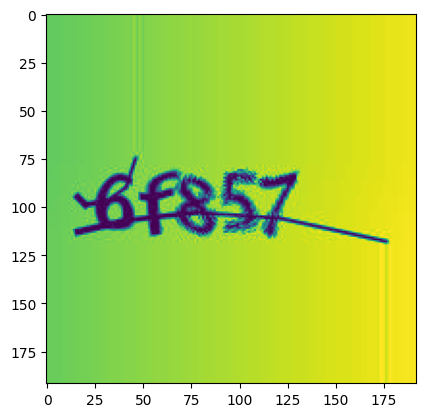

In [18]:
inputs, classes = next(iter(test_loader))
plt.imshow(inputs[0].numpy()[0])
#print(classes[0])
inputs = inputs[0:1].to(device)
#print(inputs.shape)
out1 = CNNs_5[0](inputs)
out2 = CNNs_5[1](inputs)
out3 = CNNs_5[2](inputs)
out4 = CNNs_5[3](inputs)
out5 = CNNs_5[4](inputs)

_, predicted1 = torch.max(out1, 1)
_, predicted2 = torch.max(out2, 1)
_, predicted3 = torch.max(out3, 1)
_, predicted4 = torch.max(out4, 1)
_, predicted5 = torch.max(out5, 1)

#print(out[0, classes[0]])
print("Predicted: ", (str(int_to_single_character(predicted1.cpu().numpy()[0])) +
                      str(int_to_single_character(predicted2.cpu().numpy()[0])) +
                      str(int_to_single_character(predicted3.cpu().numpy()[0])) +
                      str(int_to_single_character(predicted4.cpu().numpy()[0])) +
                      str(int_to_single_character(predicted5.cpu().numpy()[0]))))
#print(out.cpu().detach().numpy())

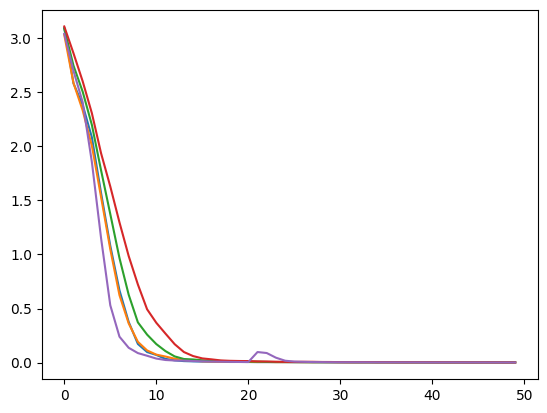

In [19]:
for loss_list in losses_lists:
    plt.plot(loss_list)
plt.show()

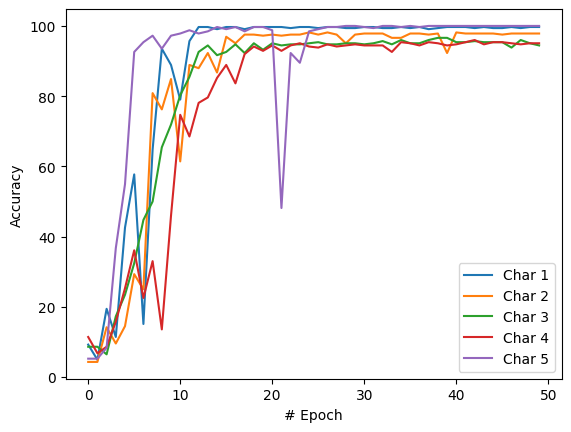

In [24]:
for acc in accuracies_by_epoch:
    plt.plot(acc)

plt.legend(["Char 1", "Char 2", "Char 3", "Char 4", "Char 5"])
plt.xlabel("# Epoch")
plt.ylabel("Accuracy")
plt.show()

In [21]:
import pickle as pkl

file = open(results_path+"Losses/cnn5_loss_curve.pkl", "wb")
pkl.dump(losses_lists,file )
file.close()
file = open(results_path+"Losses/cnn5_char_accuracy_curve.pkl", "wb")
pkl.dump(accuracies_by_epoch,file )
file.close()
#file = open(results_path+"Losses/cnn1_loss_curve.pkl", "rb")
#losses_list_p = pkl.load( file)
#file.close()

FileNotFoundError: ignored